### Senario: Mlflow is Running remotely at ec2

MLflow setup:

- Tracking server: yes, remote server (EC2).
- Backend store: postgresql database.
- Artifacts store: s3 bucket.
The experiments can be explored by accessing the remote server.

The exampe uses AWS to host a remote server. In order to run the example you'll need an AWS account. Follow the steps described in the file [`mlflow_on_aws.md`](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/02-experiment-tracking/mlflow_on_aws.md) to create a new AWS account and launch the tracking server.

In [1]:
import mlflow
import os

# os.environ["AWS_PROFILE"] = "" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

TRACKING_SERVER_HOST = "ec2-3-109-54-55.ap-south-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [2]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")


tracking URI: 'http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000'


In [4]:
mlflow.search_experiments() # list_experiments API has been removed, you can use search_experiments instead.()


[<Experiment: artifact_location='s3://mlartifact-s3/0', creation_time=1751400670126, experiment_id='0', last_update_time=1751400670126, lifecycle_stage='active', name='Default', tags={}>]

In [7]:
# set-up mflow experiment
mlflow.set_experiment("store-sales-prediction")

2025/07/28 23:24:00 INFO mlflow.tracking.fluent: Experiment with name 'store-sales-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlartifact-s3/2', creation_time=1753727040615, experiment_id='2', last_update_time=1753727040615, lifecycle_stage='active', name='store-sales-prediction', tags={}>

In [21]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# read the csv file
def read_dataframe(filename):
    df = pd.read_csv(filename)
    
    return df
    

In [11]:
# dataframe feature engineering
def feature_engineering(df):
    df["date"] = pd.to_datetime(df["date"])
    
    # Feature Engineering — Date-based features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

    # Define categorical features
    categorical = ["store", "promo", "holiday", "year", "month", "dayofweek", "is_weekend"]
    df_dicts = df[categorical].to_dict(orient="records")

    return df_dicts

In [12]:
# load and read datasets
train_df = read_dataframe("./input_data/train.csv")
test_df = read_dataframe("./input_data/test.csv")
print(train_df.shape)
print(test_df.shape)

(5840, 5)
(1460, 5)


In [13]:
# feature_engineering
train_dicts = feature_engineering(train_df)

test_dicts = feature_engineering(test_df)
print(len(test_dicts))

1460


In [14]:
# transform with DictVectorizer
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)

X_test = dv.transform(test_dicts)

# Target from dataframe
y_train = train_df["sales"].values
y_test = test_df["sales"].values

In [15]:
print(X_train.shape)
print(X_test.shape)

(5840, 7)
(1460, 7)


### Train Linear Regression Model

In [16]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# RMSE
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print("RMSE (Linear Regression):", round(rmse_lr, 2))


RMSE (Linear Regression): 13.46


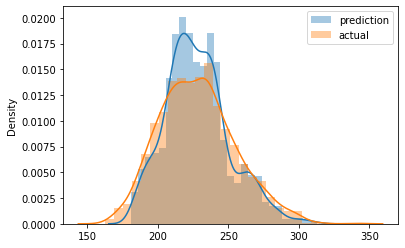

In [17]:
sns.distplot(y_pred_lr, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

In [18]:
# Save both the model and the DictVectorizer
with open("./model/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr_model), f_out)

#saved the preprocessor
with open("./model/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)

In [19]:
# Load the saved model and DictVectorizer
with open("./model/lin_reg.bin", "rb") as f_in:
    dv_loaded, model_loaded = pickle.load(f_in)

# Example usage with new data (dict format)
new_data = {"store": 1, "promo": 0, "holiday": 0, "year": 2024, "month": 12, "dayofweek": 2, "is_weekend": 0}
X_new = dv_loaded.transform([new_data])
pred = model_loaded.predict(X_new)
print("Predicted Sales:", pred[0])

Predicted Sales: 259.45766222696693


### Train Linear regression and track experiment in mlflow

In [22]:
# Tacking experiment in MLFlow

with mlflow.start_run():
    
    mlflow.set_tag("developer", "moshifa")
    mlflow.log_param("train data path","./input_data/train.csv")
    mlflow.log_param("test data path", "./input_data/test.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred_lasso = lr.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
    mlflow.log_metric("rmse", rmse)
    

🏃 View run defiant-kite-658 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/3fcf110be09143eb98ad955d2d09a77a
🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2


### XGBoost hpyerparameter optimization and tracking in mlfow experiment

In [23]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

In [25]:
def optimize_xgboost_with_mlflow(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(test, 'test')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [26]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=optimize_xgboost_with_mlflow,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[23:26:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:149.61950                                                         
[1]	test-rmse:97.89077                                                          
[2]	test-rmse:64.21386                                                          
[3]	test-rmse:42.26252                                                          
[4]	test-rmse:28.05313                                                          
[5]	test-rmse:18.92555                                                          
[6]	test-rmse:13.17905                                                          
[7]	test-rmse:9.69843                                                           
[8]	test-rmse:7.76318                                                           
[9]	test-rmse:6.80213                                                           
[10]	test-rmse:6.35163                                                 

[32]	test-rmse:6.00952                                                          
[33]	test-rmse:6.02259                                                          
[34]	test-rmse:6.03473                                                          
[35]	test-rmse:6.04233                                                          
[36]	test-rmse:6.05297                                                          
[37]	test-rmse:6.06158                                                          
[38]	test-rmse:6.07275                                                          
[39]	test-rmse:6.08216                                                          
[40]	test-rmse:6.08906                                                          
[41]	test-rmse:6.09643                                                          
[42]	test-rmse:6.10597                                                          
[43]	test-rmse:6.11155                                                          
[44]	test-rmse:6.11625      

[58]	test-rmse:6.11433                                                          
[59]	test-rmse:6.11931                                                          
[60]	test-rmse:6.12546                                                          
[61]	test-rmse:6.12906                                                          
[62]	test-rmse:6.13423                                                          
🏃 View run zealous-bear-173 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/aae4f87fe2a54f3586d5db72c9d78301

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:26:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:200.56232                                                         
[1]	test-rmse:175.67372                                                         
[2]	test-rmse:153.89125                                           

[91]	test-rmse:6.57582                                                          
🏃 View run gifted-horse-313 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/5f1509148ab5470bac90b9c14b4a9165

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:26:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:131.11845                                                         
[1]	test-rmse:75.22240                                                          
[2]	test-rmse:43.36572                                                          
[3]	test-rmse:25.29274                                                          
[4]	test-rmse:15.28470                                                          
[5]	test-rmse:9.98892                                                           
[6]	test-rmse:7.50331                                             

[31]	test-rmse:5.81756                                                          
[32]	test-rmse:5.74924                                                          
[33]	test-rmse:5.70011                                                          
[34]	test-rmse:5.66886                                                          
[35]	test-rmse:5.64249                                                          
[36]	test-rmse:5.62106                                                          
[37]	test-rmse:5.61011                                                          
[38]	test-rmse:5.60072                                                          
[39]	test-rmse:5.59579                                                          
[40]	test-rmse:5.59321                                                          
[41]	test-rmse:5.59010                                                          
[42]	test-rmse:5.58578                                                          
[43]	test-rmse:5.58559      

[29]	test-rmse:6.58266                                                          
[30]	test-rmse:6.59101                                                          
[31]	test-rmse:6.59914                                                          
[32]	test-rmse:6.60626                                                          
[33]	test-rmse:6.61151                                                          
[34]	test-rmse:6.61707                                                          
[35]	test-rmse:6.62141                                                          
[36]	test-rmse:6.62664                                                          
[37]	test-rmse:6.63124                                                          
[38]	test-rmse:6.63439                                                          
[39]	test-rmse:6.63818                                                          
[40]	test-rmse:6.64157                                                          
[41]	test-rmse:6.64415      

[61]	test-rmse:6.26161                                                          
[62]	test-rmse:6.24154                                                          
[63]	test-rmse:6.22546                                                          
[64]	test-rmse:6.21435                                                          
[65]	test-rmse:6.20600                                                          
[66]	test-rmse:6.19778                                                          
[67]	test-rmse:6.19058                                                          
[68]	test-rmse:6.18650                                                          
[69]	test-rmse:6.18248                                                          
[70]	test-rmse:6.18001                                                          
[71]	test-rmse:6.18092                                                          
[72]	test-rmse:6.17953                                                          
[73]	test-rmse:6.17748      

[57]	test-rmse:6.67672                                                          
[58]	test-rmse:6.67814                                                          
[59]	test-rmse:6.67941                                                          
[60]	test-rmse:6.68078                                                          
[61]	test-rmse:6.68198                                                          
[62]	test-rmse:6.68309                                                          
[63]	test-rmse:6.68411                                                          
[64]	test-rmse:6.68511                                                          
[65]	test-rmse:6.68598                                                          
[66]	test-rmse:6.68706                                                          
[67]	test-rmse:6.68816                                                          
[68]	test-rmse:6.68889                                                          
[69]	test-rmse:6.68980      

[81]	test-rmse:6.52742                                                          
[82]	test-rmse:6.53031                                                          
[83]	test-rmse:6.53407                                                          
[84]	test-rmse:6.53679                                                          
[85]	test-rmse:6.54027                                                          
[86]	test-rmse:6.54264                                                          
[87]	test-rmse:6.54464                                                          
[88]	test-rmse:6.54690                                                          
[89]	test-rmse:6.54894                                                          
[90]	test-rmse:6.55157                                                          
[91]	test-rmse:6.55399                                                          
[92]	test-rmse:6.55604                                                          
[93]	test-rmse:6.55813      

[7]	test-rmse:6.36543                                                           
[8]	test-rmse:6.41748                                                           
[9]	test-rmse:6.43779                                                           
[10]	test-rmse:6.48743                                                          
[11]	test-rmse:6.50338                                                          
[12]	test-rmse:6.52966                                                          
[13]	test-rmse:6.55595                                                          
[14]	test-rmse:6.56768                                                          
[15]	test-rmse:6.58283                                                          
[16]	test-rmse:6.60110                                                          
[17]	test-rmse:6.60774                                                          
[18]	test-rmse:6.61813                                                          
[19]	test-rmse:6.62616      

[49]	test-rmse:6.67457                                                          
[50]	test-rmse:6.55982                                                          
[51]	test-rmse:6.46401                                                          
[52]	test-rmse:6.38332                                                          
[53]	test-rmse:6.31670                                                          
[54]	test-rmse:6.26005                                                          
[55]	test-rmse:6.21386                                                          
[56]	test-rmse:6.17629                                                          
[57]	test-rmse:6.14633                                                          
[58]	test-rmse:6.11988                                                          
[59]	test-rmse:6.09732                                                          
[60]	test-rmse:6.07565                                                          
[61]	test-rmse:6.06079      

[45]	test-rmse:6.77737                                                          
[46]	test-rmse:6.77808                                                          
[47]	test-rmse:6.78002                                                          
[48]	test-rmse:6.78196                                                          
[49]	test-rmse:6.78418                                                          
[50]	test-rmse:6.78618                                                          
[51]	test-rmse:6.78766                                                          
[52]	test-rmse:6.78899                                                          
[53]	test-rmse:6.79093                                                          
🏃 View run gregarious-boar-813 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/1acd0920cc844df9a9e8b7bcc4d8a625

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:27:35] WARNING: 

[6]	test-rmse:6.12671                                                           
[7]	test-rmse:6.17468                                                           
[8]	test-rmse:6.22511                                                           
[9]	test-rmse:6.25465                                                           
[10]	test-rmse:6.29989                                                          
[11]	test-rmse:6.30617                                                          
[12]	test-rmse:6.30915                                                          
[13]	test-rmse:6.31926                                                          
[14]	test-rmse:6.33069                                                          
[15]	test-rmse:6.34842                                                          
[16]	test-rmse:6.36186                                                          
[17]	test-rmse:6.37567                                                          
[18]	test-rmse:6.38429      

[48]	test-rmse:5.69700                                                          
[49]	test-rmse:5.67326                                                          
[50]	test-rmse:5.65513                                                          
[51]	test-rmse:5.63954                                                          
[52]	test-rmse:5.62738                                                          
[53]	test-rmse:5.61525                                                          
[54]	test-rmse:5.60899                                                          
[55]	test-rmse:5.60230                                                          
[56]	test-rmse:5.60018                                                          
[57]	test-rmse:5.59842                                                          
[58]	test-rmse:5.59414                                                          
[59]	test-rmse:5.59401                                                          
[60]	test-rmse:5.59386      

[44]	test-rmse:6.78001                                                          
[45]	test-rmse:6.78193                                                          
[46]	test-rmse:6.78359                                                          
[47]	test-rmse:6.78540                                                          
[48]	test-rmse:6.78555                                                          
[49]	test-rmse:6.78736                                                          
[50]	test-rmse:6.78909                                                          
[51]	test-rmse:6.78984                                                          
[52]	test-rmse:6.79026                                                          
[53]	test-rmse:6.79116                                                          
[54]	test-rmse:6.79187                                                          
[55]	test-rmse:6.79303                                                          
[56]	test-rmse:6.79405      

[60]	test-rmse:6.45814                                                          
[61]	test-rmse:6.45959                                                          
[62]	test-rmse:6.46133                                                          
[63]	test-rmse:6.46300                                                          
[64]	test-rmse:6.46458                                                          
[65]	test-rmse:6.46643                                                          
[66]	test-rmse:6.46790                                                          
[67]	test-rmse:6.46895                                                          
[68]	test-rmse:6.46986                                                          
[69]	test-rmse:6.47117                                                          
[70]	test-rmse:6.47220                                                          
[71]	test-rmse:6.47292                                                          
[72]	test-rmse:6.47383      

[12]	test-rmse:113.90656                                                        
[13]	test-rmse:107.96419                                                        
[14]	test-rmse:102.34723                                                        
[15]	test-rmse:97.00964                                                         
[16]	test-rmse:91.96210                                                         
[17]	test-rmse:87.17593                                                         
[18]	test-rmse:82.63517                                                         
[19]	test-rmse:78.35143                                                         
[20]	test-rmse:74.28075                                                         
[21]	test-rmse:70.42625                                                         
[22]	test-rmse:66.77527                                                         
[23]	test-rmse:63.32218                                                         
[24]	test-rmse:60.05043     

[8]	test-rmse:143.68909                                                         
[9]	test-rmse:136.44671                                                         
[10]	test-rmse:129.57339                                                        
[11]	test-rmse:123.04515                                                        
[12]	test-rmse:116.85878                                                        
[13]	test-rmse:110.97401                                                        
[14]	test-rmse:105.38957                                                        
[15]	test-rmse:100.09308                                                        
[16]	test-rmse:95.05924                                                         
[17]	test-rmse:90.28963                                                         
[18]	test-rmse:85.76353                                                         
[19]	test-rmse:81.45768                                                         
[20]	test-rmse:77.38136     

[4]	test-rmse:176.45989                                                         
[5]	test-rmse:167.50241                                                         
[6]	test-rmse:158.99379                                                         
[7]	test-rmse:150.92781                                                         
[8]	test-rmse:143.26410                                                         
[9]	test-rmse:136.00546                                                         
[10]	test-rmse:129.10462                                                        
[11]	test-rmse:122.57012                                                        
[12]	test-rmse:116.36469                                                        
[13]	test-rmse:110.47061                                                        
[14]	test-rmse:104.88394                                                        
[15]	test-rmse:99.58491                                                         
[16]	test-rmse:94.55963     

[0]	test-rmse:212.38914                                                         
[1]	test-rmse:196.97539                                                         
[2]	test-rmse:182.70583                                                         
[3]	test-rmse:169.45510                                                         
[4]	test-rmse:157.18032                                                         
[5]	test-rmse:145.79432                                                         
[6]	test-rmse:135.24320                                                         
[7]	test-rmse:125.45172                                                         
[8]	test-rmse:116.38448                                                         
[9]	test-rmse:107.97116                                                         
[10]	test-rmse:100.16450                                                        
[11]	test-rmse:92.92426                                                         
[12]	test-rmse:86.22349     

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:28:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:206.06808                                                         
[1]	test-rmse:185.44405                                                         
[2]	test-rmse:166.90243                                                         
[3]	test-rmse:150.23657                                                         
[4]	test-rmse:135.21535                                                         
[5]	test-rmse:121.76172                                                         
[6]	test-rmse:109.68703                                                         
[7]	test-rmse:98.78244                                                          
[8]	test-rmse:89.03993                                                          
[9]	test-rmse:80.24800                              

[98]	test-rmse:5.39587                                                          
[99]	test-rmse:5.38650                                                          
🏃 View run thundering-wren-190 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/3de5a67c33994a2cb50e699d63ef51f3

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:28:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:206.98687                                                         
[1]	test-rmse:187.08213                                                         
[2]	test-rmse:169.10205                                                         
[3]	test-rmse:152.86885                                                         
[4]	test-rmse:138.19730                                                         
[5]	test-rmse:124.97156                                        

[94]	test-rmse:5.41657                                                          
[95]	test-rmse:5.41638                                                          
[96]	test-rmse:5.41617                                                          
[97]	test-rmse:5.41518                                                          
[98]	test-rmse:5.41489                                                          
[99]	test-rmse:5.41314                                                          
🏃 View run calm-hound-245 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/7413fb4a32f1417c9ad258066a46770b

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:28:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:204.92521                                                         
[1]	test-rmse:183.37513                                             

[90]	test-rmse:5.43352                                                          
[91]	test-rmse:5.43401                                                          
[92]	test-rmse:5.43726                                                          
[93]	test-rmse:5.43794                                                          
[94]	test-rmse:5.44000                                                          
[95]	test-rmse:5.44117                                                          
[96]	test-rmse:5.44365                                                          
[97]	test-rmse:5.44496                                                          
[98]	test-rmse:5.44483                                                          
[99]	test-rmse:5.44450                                                          
🏃 View run popular-bass-611 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/6e0f1f30c1424a3a8b13c8883b53d240

🧪 View experiment at: http://ec2-3-109-54-

[86]	test-rmse:5.83368                                                          
[87]	test-rmse:5.81193                                                          
[88]	test-rmse:5.79138                                                          
[89]	test-rmse:5.75933                                                          
[90]	test-rmse:5.73901                                                          
[91]	test-rmse:5.71755                                                          
[92]	test-rmse:5.69926                                                          
[93]	test-rmse:5.68882                                                          
[94]	test-rmse:5.66627                                                          
[95]	test-rmse:5.65305                                                          
[96]	test-rmse:5.62996                                                          
[97]	test-rmse:5.61765                                                          
[98]	test-rmse:5.60483      

[82]	test-rmse:6.04369                                                          
[83]	test-rmse:6.04743                                                          
[84]	test-rmse:6.05314                                                          
[85]	test-rmse:6.05658                                                          
[86]	test-rmse:6.05989                                                          
🏃 View run fun-stork-357 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/2141ad51476944a5850f06e4a0092f9e

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:29:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:207.52119                                                         
[1]	test-rmse:188.05528                                                         
[2]	test-rmse:170.42449                                              

[91]	test-rmse:5.40147                                                          
[92]	test-rmse:5.40002                                                          
[93]	test-rmse:5.39696                                                          
[94]	test-rmse:5.39540                                                          
[95]	test-rmse:5.39252                                                          
[96]	test-rmse:5.39092                                                          
[97]	test-rmse:5.39012                                                          
[98]	test-rmse:5.38952                                                          
[99]	test-rmse:5.38918                                                          
🏃 View run intelligent-fly-20 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/961b7be498a34f95a29fbce7a96ff9d6

🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2

[23:29:22] WARNING: .

[87]	test-rmse:5.96792                                                          
[88]	test-rmse:5.96247                                                          
[89]	test-rmse:5.96087                                                          
[90]	test-rmse:5.95727                                                          
[91]	test-rmse:5.95453                                                          
[92]	test-rmse:5.95441                                                          
[93]	test-rmse:5.95421                                                          
[94]	test-rmse:5.95548                                                          
[95]	test-rmse:5.95426                                                          
[96]	test-rmse:5.95808                                                          
[97]	test-rmse:5.96234                                                          
[98]	test-rmse:5.96482                                                          
[99]	test-rmse:5.96835      

[22]	test-rmse:7.81090                                                          
[23]	test-rmse:7.28135                                                          
[24]	test-rmse:6.86518                                                          
[25]	test-rmse:6.54278                                                          
[26]	test-rmse:6.32059                                                          
[27]	test-rmse:6.15214                                                          
[28]	test-rmse:6.03407                                                          
[29]	test-rmse:5.95146                                                          
[30]	test-rmse:5.88878                                                          
[31]	test-rmse:5.84953                                                          
[32]	test-rmse:5.81184                                                          
[33]	test-rmse:5.79399                                                          
[34]	test-rmse:5.78426      

[31]	test-rmse:13.72936                                                         
[32]	test-rmse:12.93950                                                         
[33]	test-rmse:12.24107                                                         
[34]	test-rmse:11.61574                                                         
[35]	test-rmse:11.04216                                                         
[36]	test-rmse:10.46968                                                         
[37]	test-rmse:10.03136                                                         
[38]	test-rmse:9.66668                                                          
[39]	test-rmse:9.24724                                                          
[40]	test-rmse:8.94755                                                          
[41]	test-rmse:8.67413                                                          
[42]	test-rmse:8.44903                                                          
[43]	test-rmse:8.22716      

[27]	test-rmse:8.61449                                                          
[28]	test-rmse:8.03592                                                          
[29]	test-rmse:7.56962                                                          
[30]	test-rmse:7.17818                                                          
[31]	test-rmse:6.85917                                                          
[32]	test-rmse:6.60605                                                          
[33]	test-rmse:6.40433                                                          
[34]	test-rmse:6.24283                                                          
[35]	test-rmse:6.11421                                                          
[36]	test-rmse:6.01241                                                          
[37]	test-rmse:5.93866                                                          
[38]	test-rmse:5.87539                                                          
[39]	test-rmse:5.82777      

[23]	test-rmse:50.32759                                                         
[24]	test-rmse:47.28332                                                         
[25]	test-rmse:44.43633                                                         
[26]	test-rmse:41.76550                                                         
[27]	test-rmse:39.25825                                                         
[28]	test-rmse:36.90650                                                         
[29]	test-rmse:34.70764                                                         
[30]	test-rmse:32.64122                                                         
[31]	test-rmse:30.71129                                                         
[32]	test-rmse:28.89536                                                         
[33]	test-rmse:27.20327                                                         
[34]	test-rmse:25.61073                                                         
[35]	test-rmse:24.12836     

[19]	test-rmse:5.78216                                                          
[20]	test-rmse:5.78844                                                          
[21]	test-rmse:5.80054                                                          
[22]	test-rmse:5.82285                                                          
[23]	test-rmse:5.83836                                                          
[24]	test-rmse:5.85003                                                          
[25]	test-rmse:5.86679                                                          
[26]	test-rmse:5.87454                                                          
[27]	test-rmse:5.89040                                                          
[28]	test-rmse:5.90985                                                          
[29]	test-rmse:5.92485                                                          
[30]	test-rmse:5.93944                                                          
[31]	test-rmse:5.95744      

[45]	test-rmse:6.36190                                                          
[46]	test-rmse:6.37026                                                          
[47]	test-rmse:6.37800                                                          
[48]	test-rmse:6.38376                                                          
[49]	test-rmse:6.39192                                                          
[50]	test-rmse:6.39975                                                          
[51]	test-rmse:6.40645                                                          
[52]	test-rmse:6.41518                                                          
[53]	test-rmse:6.41857                                                          
[54]	test-rmse:6.42364                                                          
[55]	test-rmse:6.42886                                                          
[56]	test-rmse:6.43479                                                          
[57]	test-rmse:6.44048      

[60]	test-rmse:6.08018                                                          
[61]	test-rmse:6.08922                                                          
[62]	test-rmse:6.09813                                                          
[63]	test-rmse:6.10287                                                          
[64]	test-rmse:6.11026                                                          
[65]	test-rmse:6.11541                                                          
[66]	test-rmse:6.12275                                                          
[67]	test-rmse:6.13022                                                          
[68]	test-rmse:6.13796                                                          
[69]	test-rmse:6.14638                                                          
[70]	test-rmse:6.15064                                                          
[71]	test-rmse:6.15747                                                          
[72]	test-rmse:6.16525      

[63]	test-rmse:5.92585                                                          
[64]	test-rmse:5.93234                                                          
[65]	test-rmse:5.93738                                                          
[66]	test-rmse:5.94179                                                          
[67]	test-rmse:5.94471                                                          
[68]	test-rmse:5.94918                                                          
[69]	test-rmse:5.95216                                                          
[70]	test-rmse:5.95952                                                          
[71]	test-rmse:5.96588                                                          
[72]	test-rmse:5.97321                                                          
[73]	test-rmse:5.97870                                                          
[74]	test-rmse:5.98192                                                          
🏃 View run charming-moose-89

[84]	test-rmse:6.12581                                                          
[85]	test-rmse:6.13345                                                          
[86]	test-rmse:6.13956                                                          
[87]	test-rmse:6.14558                                                          
[88]	test-rmse:6.15236                                                          
[89]	test-rmse:6.15846                                                          
[90]	test-rmse:6.16506                                                          
[91]	test-rmse:6.17068                                                          
[92]	test-rmse:6.17653                                                          
[93]	test-rmse:6.18282                                                          
[94]	test-rmse:6.18880                                                          
[95]	test-rmse:6.19480                                                          
[96]	test-rmse:6.20003      

[16]	test-rmse:65.82311                                                         
[17]	test-rmse:61.20409                                                         
[18]	test-rmse:56.91328                                                         
[19]	test-rmse:52.92518                                                         
[20]	test-rmse:49.22623                                                         
[21]	test-rmse:45.78987                                                         
[22]	test-rmse:42.60602                                                         
[23]	test-rmse:39.65434                                                         
[24]	test-rmse:36.91004                                                         
[25]	test-rmse:34.36941                                                         
[26]	test-rmse:32.00940                                                         
[27]	test-rmse:29.82769                                                         
[28]	test-rmse:27.80364     

[12]	test-rmse:6.30403                                                          
[13]	test-rmse:6.16426                                                          
[14]	test-rmse:6.09324                                                          
[15]	test-rmse:6.08737                                                          
[16]	test-rmse:6.10874                                                          
[17]	test-rmse:6.13223                                                          
[18]	test-rmse:6.15526                                                          
[19]	test-rmse:6.18038                                                          
[20]	test-rmse:6.19997                                                          
[21]	test-rmse:6.22015                                                          
[22]	test-rmse:6.24213                                                          
[23]	test-rmse:6.26796                                                          
[24]	test-rmse:6.29057      

[43]	test-rmse:5.69914                                                          
[44]	test-rmse:5.67432                                                          
[45]	test-rmse:5.65310                                                          
[46]	test-rmse:5.63449                                                          
[47]	test-rmse:5.62595                                                          
[48]	test-rmse:5.62097                                                          
[49]	test-rmse:5.61702                                                          
[50]	test-rmse:5.61255                                                          
[51]	test-rmse:5.61320                                                          
[52]	test-rmse:5.61253                                                          
[53]	test-rmse:5.61500                                                          
[54]	test-rmse:5.61648                                                          
[55]	test-rmse:5.62134      

[39]	test-rmse:8.23543                                                          
[40]	test-rmse:7.93047                                                          
[41]	test-rmse:7.66397                                                          
[42]	test-rmse:7.43684                                                          
[43]	test-rmse:7.24474                                                          
[44]	test-rmse:7.08287                                                          
[45]	test-rmse:6.94762                                                          
[46]	test-rmse:6.83043                                                          
[47]	test-rmse:6.72938                                                          
[48]	test-rmse:6.65020                                                          
[49]	test-rmse:6.58810                                                          
[50]	test-rmse:6.53545                                                          
[51]	test-rmse:6.49081      

[35]	test-rmse:5.88568                                                          
[36]	test-rmse:5.85136                                                          
[37]	test-rmse:5.82687                                                          
[38]	test-rmse:5.80444                                                          
[39]	test-rmse:5.79526                                                          
[40]	test-rmse:5.78802                                                          
[41]	test-rmse:5.78784                                                          
[42]	test-rmse:5.78412                                                          
[43]	test-rmse:5.78147                                                          
[44]	test-rmse:5.78623                                                          
[45]	test-rmse:5.78648                                                          
[46]	test-rmse:5.79049                                                          
[47]	test-rmse:5.79342      

[37]	test-rmse:5.71642                                                          
[38]	test-rmse:5.72285                                                          
[39]	test-rmse:5.72624                                                          
[40]	test-rmse:5.73491                                                          
[41]	test-rmse:5.73823                                                          
[42]	test-rmse:5.74748                                                          
[43]	test-rmse:5.75360                                                          
[44]	test-rmse:5.76094                                                          
[45]	test-rmse:5.76297                                                          
[46]	test-rmse:5.76699                                                          
[47]	test-rmse:5.77155                                                          
[48]	test-rmse:5.77744                                                          
[49]	test-rmse:5.78258      

[58]	test-rmse:9.19973                                                          
[59]	test-rmse:8.87439                                                          
[60]	test-rmse:8.57694                                                          
[61]	test-rmse:8.30341                                                          
[62]	test-rmse:8.05005                                                          
[63]	test-rmse:7.81694                                                          
[64]	test-rmse:7.60493                                                          
[65]	test-rmse:7.41515                                                          
[66]	test-rmse:7.23847                                                          
[67]	test-rmse:7.08077                                                          
[68]	test-rmse:6.93447                                                          
[69]	test-rmse:6.80452                                                          
[70]	test-rmse:6.68727      

[54]	test-rmse:6.93813                                                          
[55]	test-rmse:6.83413                                                          
[56]	test-rmse:6.74402                                                          
[57]	test-rmse:6.66423                                                          
[58]	test-rmse:6.59635                                                          
[59]	test-rmse:6.53714                                                          
[60]	test-rmse:6.48823                                                          
[61]	test-rmse:6.44751                                                          
[62]	test-rmse:6.41301                                                          
[63]	test-rmse:6.38416                                                          
[64]	test-rmse:6.36144                                                          
[65]	test-rmse:6.34024                                                          
[66]	test-rmse:6.32368      

### Train XGboost with best parameter and adding preprocesser to log data in mlflow


In [27]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "moshifa")
    mlflow.log_param("train data path","./input_data/train.csv")
    mlflow.log_param("test data path", "./input_data/test.csv")
    
    best_params = { 
    "objective":"reg:linear",
    "reg_lambda":0.07393340591462957,
    "reg_alpha":0.022104239962036157,
    "max_depth":4,
    "learning_rate":0.1727129051887762,
    "min_child_weight":13.54003751573338,
    "seed":42
    }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=100,
                evals=[(test, 'test')],
                early_stopping_rounds=50
            )
    y_pred = booster.predict(test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
#     with open("./../saved_model/preprocessor.b", "wb") as f_out:
#         pickle.dump(dv, f_out)
    
    mlflow.log_artifact("./model/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="xgboost_models_mlflow")

[23:36:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:189.60679
[1]	test-rmse:157.05869
[2]	test-rmse:130.11882
[3]	test-rmse:107.87442
[4]	test-rmse:89.54393
[5]	test-rmse:74.34411
[6]	test-rmse:61.88211
[7]	test-rmse:51.56385
[8]	test-rmse:43.07593
[9]	test-rmse:36.11898
[10]	test-rmse:30.38698
[11]	test-rmse:25.69077
[12]	test-rmse:21.87526
[13]	test-rmse:18.77267
[14]	test-rmse:16.31643
[15]	test-rmse:14.38292
[16]	test-rmse:12.72078
[17]	test-rmse:11.42736
[18]	test-rmse:10.41649
[19]	test-rmse:9.61627
[20]	test-rmse:9.05579
[21]	test-rmse:8.53905
[22]	test-rmse:8.13869
[23]	test-rmse:7.85510
[24]	test-rmse:7.60820
[25]	test-rmse:7.41654
[26]	test-rmse:7.10671
[27]	test-rmse:6.97912
[28]	test-rmse:6.83173
[29]	test-rmse:6.69383
[30]	test-rmse:6.61841
[31]	test-rmse:6.49476
[32]	test-rmse:6.41192
[33]	test-rmse:6.32263
[34]	test-rmse:6.27642
[35]	test-rmse:6.21188
[36]	test-rmse:6.04140
[37]	test-rmse:5.

2025/07/28 23:36:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ambitious-ape-90 at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2/runs/391f98daac394c54a4c99841562e19ca
🧪 View experiment at: http://ec2-3-109-54-55.ap-south-1.compute.amazonaws.com:5000/#/experiments/2


In [28]:
mlflow.search_experiments()

[<Experiment: artifact_location='s3://mlartifact-s3/2', creation_time=1753727040615, experiment_id='2', last_update_time=1753727040615, lifecycle_stage='active', name='store-sales-prediction', tags={}>,
 <Experiment: artifact_location='s3://mlartifact-s3/0', creation_time=1751400670126, experiment_id='0', last_update_time=1751400670126, lifecycle_stage='active', name='Default', tags={}>]

### Interacting with the model registry


In [31]:
TRACKING_SERVER_HOST = "ec2-13-233-121-70.ap-south-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance

In [33]:
from mlflow.tracking import MlflowClient


client = MlflowClient(f"http://{TRACKING_SERVER_HOST}:5000")


In [34]:
client.search_registered_models()

[]

In [43]:
run_id = client.search_runs(experiment_ids='2')[0].info.run_id
mlflow.register_model(
    model_uri=f"runs:/{run_id}/xgboost_models_mlflow",
    name='store-sales-prediction'
)

Successfully registered model 'store-sales-prediction'.
2025/07/29 00:32:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: store-sales-prediction, version 1
Created version '1' of model 'store-sales-prediction'.


<ModelVersion: aliases=[], creation_timestamp=1753731142560, current_stage='None', description='', last_updated_timestamp=1753731142560, name='store-sales-prediction', run_id='391f98daac394c54a4c99841562e19ca', run_link='', source='s3://mlartifact-s3/2/391f98daac394c54a4c99841562e19ca/artifacts/xgboost_models_mlflow', status='READY', status_message=None, tags={}, user_id='', version='1'>

In [44]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1753731140017, description='', last_updated_timestamp=1753731142560, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1753731142560, current_stage='None', description='', last_updated_timestamp=1753731142560, name='store-sales-prediction', run_id='391f98daac394c54a4c99841562e19ca', run_link='', source='s3://mlartifact-s3/2/391f98daac394c54a4c99841562e19ca/artifacts/xgboost_models_mlflow', status='READY', status_message=None, tags={}, user_id='', version='1'>], name='store-sales-prediction', tags={}>]

### load trained models in two available flavors


In [45]:
# take this run_id from mlfow experiment
run_id = "391f98daac394c54a4c99841562e19ca"
logged_model = f'runs:/{run_id}/xgboost_models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

[00:33:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [46]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: xgboost_models_mlflow
  flavor: mlflow.xgboost
  run_id: 391f98daac394c54a4c99841562e19ca

In [47]:
##load model as a xgboost
xgboost = mlflow.xgboost.load_model(logged_model)

[00:33:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [48]:
xgboost

### Make prediciton on loaded model

In [49]:
mlflow_model_prediction = xgboost.predict(test)

In [50]:
mlflow_model_prediction[:5]

array([205.51517, 209.0153 , 271.03152, 230.04356, 191.57927],
      dtype=float32)